In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

class DataPrep():
    def __init__(self):
        self.trait_cat_dict = {
            'O': 'cOPN',
            'C': 'cCON',
            'E': 'cEXT',
            'A': 'cAGR',
            'N': 'cNEU',
            'OPN': 'cOPN',
            'CON': 'cCON',
            'EXT': 'cEXT',
            'AGR': 'cAGR',
            'NEU': 'cNEU',
            'Openness': 'cOPN',
            'Conscientiousness': 'cCON',
            'Extraversion': 'cEXT',
            'Agreeableness': 'cAGR',
            'Neuroticism': 'cNEU'
            }
        self.trait_score_dict = {
            'O': 'sOPN',
            'C': 'sCON',
            'E': 'sEXT',
            'A': 'sAGR',
            'N': 'sNEU',
            'OPN': 'sOPN',
            'CON': 'sCON',
            'EXT': 'sEXT',
            'AGR': 'sAGR',
            'NEU': 'sNEU',
            'Openness': 'sOPN',
            'Conscientiousness': 'sCON',
            'Extraversion': 'sEXT',
            'Agreeableness': 'sAGR',
            'Neuroticism': 'sNEU'
            }
        self.LIWC_features = [
            'WPS', 'Unique', 'Dic', 'Sixltr', 'Negate', 'Assent', 'Article', 'Preps', 'Number',
            'Pronoun', 'I', 'We', 'Self', 'You', 'Other',
            'Affect', 'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx', 'Anger', 'Sad',
            'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib', 'Tentat', 'Certain',
            'Senses', 'See', 'Hear', 'Feel',
            'Social', 'Comm', 'Othref', 'Friends', 'Family', 'Humans',
            'Time', 'Past', 'Present', 'Future',
            'Space', 'Up', 'Down', 'Incl', 'Excl', 'Motion',
            'Occup', 'School', 'Job', 'Achieve',
            'Leisure', 'Home', 'Sports', 'TV', 'Music',
            'Money',
            'Metaph', 'Relig', 'Death', 'Physcal', 'Body', 'Sexual', 'Eating', 'Sleep', 'Groom',
            'Allpct', 'Period', 'Comma', 'Colon', 'Semic', 'Qmark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'Otherp',
            'Swear', 'Nonfl', 'Fillers',
        ]

    def prep_data(self, type, trait, regression=False, model_comparison=False):
        df_tweet = self.prep_status_data()
        # df_essay = self.prep_essay_data()

        tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

        if type == 'tweet':
            # Include other features with tfidf vector
#             other_features_columns = [
#                 'NETWORKSIZE',
#                 'BETWEENNESS',
#                 'NBETWEENNESS',
#                 'DENSITY',
#                 'BROKERAGE',
#                 'NBROKERAGE',
#                 'TRANSITIVITY'
#             ]
            X = tfidf.fit_transform(df_tweet['TWEET']).todense()

#             X = df_tweet['TWEET']

            if regression:
                y_column = self.trait_score_dict[trait]
            else:
                y_column = self.trait_cat_dict[trait]
            y = df_tweet[y_column]

#         print(y)
        return X, y


    def prep_status_data(self):
        df = pd.read_csv('mypersonality_final.csv', encoding="ISO-8859-1")
        df.rename(columns = {'STATUS':'TWEET'}, inplace = True)
        df = self.convert_traits_to_boolean(df)
#         print(df)
        return df


    def convert_traits_to_boolean(self, df):
        trait_columns = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']
        d = {'y': True, 'n': False}

        for trait in trait_columns:
            df[trait] = df[trait].map(d)

        return df


    def load_data(self, filepath):
        return pd.read_csv(filepath, encoding="ISO-8859-1")
    



In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
# from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

class ModelEvaluator():
    def __init__(self, X, y, trait):
        self.X = X
        self.y = y
        self.trait = trait
        self.models_dict = {
            'LogisticRegression': LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(max_features='sqrt', n_estimators=110),
            'MultinomialNB': MultinomialNB(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'SVC': SVC(),
            'LinearRegression': LinearRegression(),
            'RandomForestRegressor' : RandomForestRegressor(
                 bootstrap=True,
                 # max_depth=50,
                 max_features='sqrt',
                 min_samples_leaf=1,
                 min_samples_split=2,
                 n_estimators= 200),
            'Ridge': Ridge(),
            'SGDRegressor': SGDRegressor(),
            'MLPRegressor': MLPRegressor(learning_rate_init=0.0001,activation='relu',
                     solver='adam',alpha=0.0001,max_iter=1000,batch_size=1000,
                     early_stopping = True,learning_rate = 'adaptive'),
            'MLPClassifier': MLPClassifier(random_state=1, max_iter=300),
#             'LGBMClassifier': LGBMClassifier(),
#             'LGBMRegressor': LGBMRegressor(),
            'XGBClassifier': XGBClassifier(learning_rate=0.01, n_estimators=1000, max_depth=10, subsample=0.8,
                                          colsample_bytree=1, gamma=1, objective='binary:logistic', reg_alpha=0.3,
                                          scale_pos_weight=1),
            'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
            'CatBoostClassifier': CatBoostClassifier(verbose=0, n_estimators=100),
            'CatBoostRegressor': CatBoostRegressor(verbose=0, n_estimators=100),
            'HistGradientBoostingClassifier': HistGradientBoostingClassifier(),
            'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
        }
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=32)
        self.hyperparameters = {
        'RandomForestClassifier': {'max_features': 'sqrt', 'n_estimators': 110},

        }

    def tune_hyperparameters(self, model):
        traits = ['O', 'C', 'E', 'A', 'N']
        trait_best_params_dict = {}
        for trait in traits:
            if model == 'RandomForestRegressor':

                # Number of trees in random forest
                n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
                # Number of features to consider at every split
                max_features = ['auto', 'sqrt']
                # Maximum number of levels in tree
                max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
                max_depth.append(None)
                # Minimum number of samples required to split a node
                min_samples_split = [2, 5, 10]
                # Minimum number of samples required at each leaf node
                min_samples_leaf = [1, 2, 4]
                # Method of selecting samples for training each tree
                bootstrap = [True, False]
                # Create the random grid
                random_grid = {'n_estimators': n_estimators,
                               'max_features': max_features,
                               # 'max_depth': max_depth,
                               # 'min_samples_split': min_samples_split,
                               # 'min_samples_leaf': min_samples_leaf,
                               # 'bootstrap': bootstrap
                               }


                # Use the random grid to search for best hyperparameters
                # First create the base model to tune
                rf = RandomForestRegressor()
                # Random search of parameters, using 3 fold cross validation,

                # search across 100 different combinations, and use all available cores
                # rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

                rf_GSCV = GridSearchCV(estimator=rf, param_grid=random_grid, cv=5)

                # Fit the random search model
                rf_GSCV.fit(self.X, self.y)
                print('Personality ' + trait + ' best params: ' )
                for k, v in rf_GSCV.best_params_:
                    print (k + ': ' + v)
                trait_best_params_dict[trait] = rf_GSCV.best_params_

        return trait_best_params_dict

    def compare_scores(self, models, regression=False):
        print('Model performance for trait->' + self.trait + ' prediction:' + '\n')

        accuracy_scores = []
        f1_scores = []
        
        mse_regression = []

        for model_name in models:
            model = self.models_dict[model_name]
            model.fit(self.X_train, self.y_train)

            print("\t" + model_name + ": ")

            if regression:
                y_pred = model.predict(self.X_test)
                y_true = self.y_test
                mse = -np.mean(cross_validate(model, self.X_test, self.y_test, scoring='neg_mean_squared_error', cv=10)['test_score'])
                mse_regression.append({model_name : mse})
                print('\t\tMSE: ' + str(mse))
            else:
                accuracy_score = np.mean(cross_validate(model, self.X_test, self.y_test, cv=10)['test_score'])
                accuracy_scores.append(accuracy_score)
                print('\t\tAccuracy score: ' + str(accuracy_score))

                # y_pred = model.predict(self.X_test).round()
                # y_true = self.y_test
                # f_score = f1_score(y_true, y_pred)
                f_score = np.mean(cross_validate(model, self.X_test, self.y_test, scoring='f1', cv=10)['test_score'])
                f1_scores.append(f_score)
                print('\t\tF1 score: ' + str(f_score) + '\n')

        if regression:
            return mse_regression
            pass
        else:
            best_accuracy_score = max(accuracy_scores)
            best_accuracy_model = models[accuracy_scores.index(best_accuracy_score)]
            print(
                '\tBest Accuracy score: ' + str(best_accuracy_score) + '\n' +
                '\tModel: ' + best_accuracy_model  + '\n'
            )
            best_f1_score = max(f1_scores)
            best_f1_model = models[f1_scores.index(best_f1_score)]
            print(
                '\tBest F1 score: ' + str(best_f1_score) + '\n' +
                '\tModel: ' + best_f1_model + '\n'
            )
            return accuracy_scores, f1_scores

# if __name__ == '__main__':
#     dp = DataPrep()
    
#     X, y = dp.prep_data('tweet', 'OPN', regression=False, model_comparison=False)
    
    
#     M = ModelEvaluator(X, y, 'OPN')
    
#     models = ['GradientBoostingClassifier', 'MLPClassifier']
    
#     M.compare_scores(models)

if __name__ == '__main__':
    
    
    traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
    
    data_mse = []
    data_accuracy_score = []
    data_f1_score = []
    
    for trait in traits:        
        dp = DataPrep()
        X_classification, y_classification = dp.prep_data('tweet', trait, regression=False, model_comparison=False)
        X_regression, y_regression = dp.prep_data('tweet', trait, regression=False, model_comparison=False)

        
        M1 = ModelEvaluator(X_classification, y_classification, trait)
#         M2 = ModelEvaluator(X_regression, y_regression, trait)

#         models_classifier = ['GradientBoostingClassifier', 'MLPClassifier', 'SVC', 'MultinomialNB', 'HistGradientBoostingClassifier', 'XGBClassifier']     
#         models_regressor = ['LogisticRegression', 'LinearRegression', 'RandomForestRegressor', 'Ridge', 'SGDRegressor', 'MLPRegressor', 'HistGradientBoostingRegressor', 'XGBRegressor']

        models_classifier = ['RandomForestClassifier']
    
        accuracy_score, f1_score = M1.compare_scores(models_classifier)
        data_accuracy_score.append({trait: accuracy_score})
        data_f1_score.append({trait: f1_score})
        
        
#         mse = M2.compare_scores(models_regressor, regression=True)
#         data_mse.append({trait: mse})

Model performance for trait->OPN prediction:



KeyboardInterrupt: 

In [4]:
print(data_mse)

[]


In [5]:
print(data_accuracy_score)

[{'OPN': [0.7293037219363019]}, {'CON': [0.5469083314686358]}, {'EXT': [0.576833930036548]}, {'AGR': [0.5279695308420974]}, {'NEU': [0.6266465279331692]}]


In [6]:
print(data_f1_score)

[{'OPN': [0.8409303644045595]}, {'CON': [0.39303423273227517]}, {'EXT': [0.3225881813293189]}, {'AGR': [0.6076829771127769]}, {'NEU': [0.20421039622029377]}]


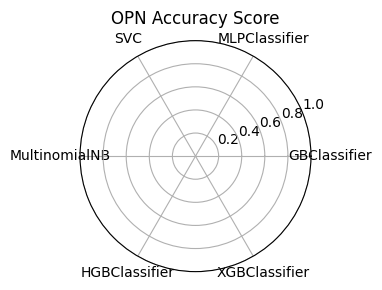

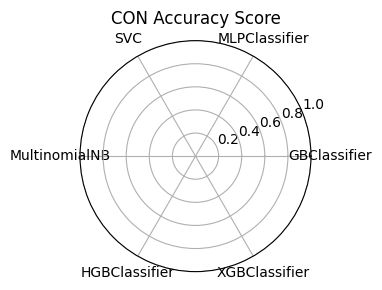

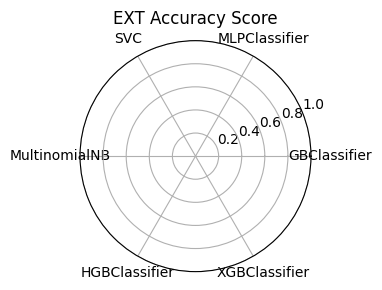

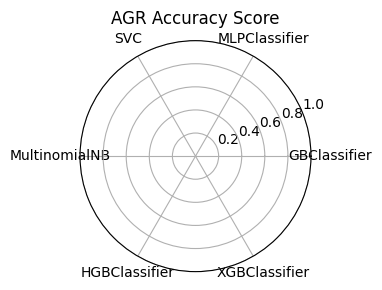

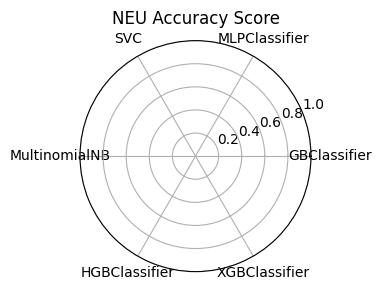

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# vlaues = list(data_accuracy_score[0].values())[0][:-8]
# data_accuracy_score[0]['OPN'] = [0.7332690012679943, 0.6517052659058701, 0.7335757440143209, 0.734798985604535, 0.7079147087342432, 0.7219735958827478]

traits = ["OPN", "CON", "EXT", "AGR", "NEU"]

for i in range(5):
    
 
    keys = ['GBClassifier', 'MLPClassifier', 'SVC', 'MultinomialNB', 'HGBClassifier', 'XGBClassifier']

    values2 = list(data_accuracy_score[i].values())[0].copy()

    values2.append(values2[0])
#     print(values2)


    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(7, 3))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2*np.pi, len(values2), endpoint=True)

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(keys))), (keys))

    # Plot actual sales graph
    # plt.plot(theta, actual)


    # Plot expected sales graph
    plt.plot(theta, values2)
    plt.fill(theta, values2, 'b', alpha=0.1)
    # plt.rmax(2)
    plt.ylim(0, 1)


    # Add legend and title for the plot
    # plt.legend(labels=('Actual'), loc=1)
    plt.title(traits[i] + " Accuracy Score")

    # Dsiplay the plot on the screen
    plt.show()
    print('\n\n\n')



# print(values)

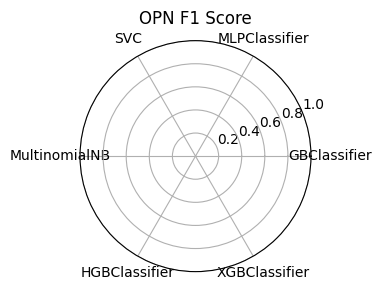

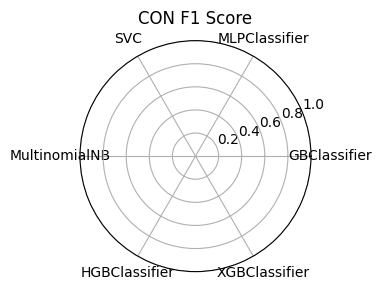

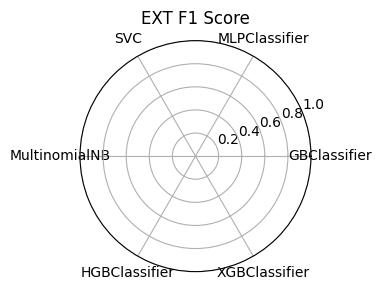

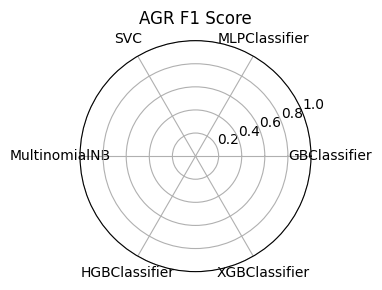

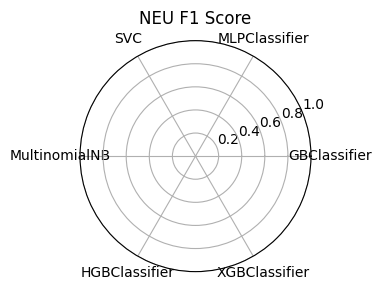

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# vlaues = list(data_accuracy_score[0].values())[0][:-8]
# data_accuracy_score[0]['OPN'] = [0.7332690012679943, 0.6517052659058701, 0.7335757440143209, 0.734798985604535, 0.7079147087342432, 0.7219735958827478]

traits = ["OPN", "CON", "EXT", "AGR", "NEU"]

for i in range(5):
    
 
    keys = ['GBClassifier', 'MLPClassifier', 'SVC', 'MultinomialNB', 'HGBClassifier', 'XGBClassifier']

    values2 = list(data_f1_score[i].values())[0].copy()

    values2.append(values2[0])
#     print(values2)


    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(7, 3))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2*np.pi, len(values2), endpoint=True)

    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(keys))), (keys))

    # Plot actual sales graph
    # plt.plot(theta, actual)


    # Plot expected sales graph
    plt.plot(theta, values2)
    plt.fill(theta, values2, 'b', alpha=0.1)
    # plt.rmax(2)
    plt.ylim(0, 1)


    # Add legend and title for the plot
    # plt.legend(labels=('Actual'), loc=1)
    plt.title(traits[i] + " F1 Score")

    # Dsiplay the plot on the screen
    plt.show()
    print('\n\n\n')



# print(values)